## Семинар 2 "Распознавание рукописных цифр"

ФИО: Токаева Александра Александровна

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

import seaborn as sns
from tqdm import tqdm

In [112]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [113]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

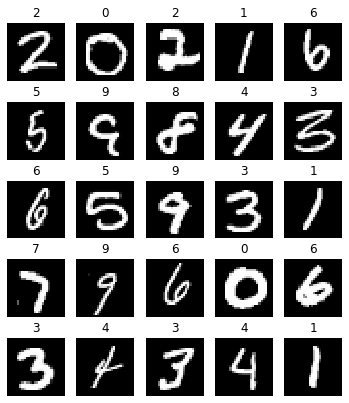

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [114]:
def TeachNN(train_loader, test_loader, activation_func,number_ep=5,lr=0.01):

    layers=[Linear(28*28,100), activation_func(), Linear(100,100), activation_func(), Linear(100,10)]
    nn=NeuralNetwork(layers)
    loss_neuron=NLLLoss()


    
    mas_of_train_losses=[]
    mas_of_test_losses=[]

    for epoch in tqdm(range(number_ep)):
        
        for X, y in train_loader:
            X = X.view(X.shape[0], -1)
            X = X.numpy() ### Converts torch.Tensor to numpy array
            y = y.numpy()

            preds=nn.forward(X)
            tek_loss=loss_neuron.forward(preds,y)
            mas_of_train_losses.append(tek_loss)
            dLdpreds=loss_neuron.backward()
            nn.backward(dLdpreds)
            nn.step(lr)

        for X, y in test_loader:
            X = X.view(X.shape[0], -1)
            X = X.numpy() ### Converts torch.Tensor to numpy array
            y = y.numpy()

            preds=nn.forward(X)
            tek_loss=loss_neuron.forward(preds,y)
            mas_of_test_losses.append(tek_loss)
            
    return nn,mas_of_train_losses, mas_of_test_losses

In [115]:
def draw_losses(mas_train,mas_test):

    fig, axes = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    axes[0].plot(np.arange(len(mas_train)),mas_train,c='blue') 
    axes[0].set_title('Train_losses')
    axes[0].set_xlabel('Nomer of batch')
    axes[0].set_ylabel('NLLLoss on this batch')

    axes[1].plot(np.arange(len(mas_test)),mas_test,c='orange') 
    axes[1].set_title('Test_losses')
    axes[1].set_xlabel('Nomer of batch')
    axes[1].set_ylabel('NLLLoss on this batch')

    plt.show()



100%|██████████| 10/10 [03:33<00:00, 19.50s/it]


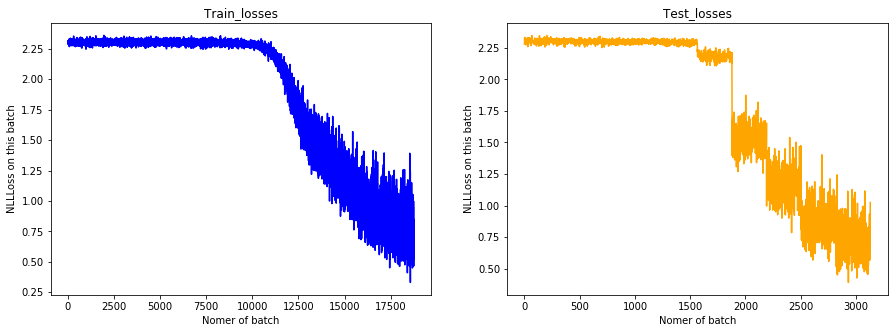

In [20]:
_,mas_sigm_train,mas_sigm_test=TeachNN(train_loader, test_loader,Sigmoid,10,0.01)
draw_losses(mas_sigm_train,mas_sigm_test)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [17]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = (X > 0).astype(float)*X
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.s > 0).astype(float)*dLdy
    
    def step(self, learning_rate):
        pass

In [18]:
class ELU:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.mask= (X > 0).astype(float)
        self.X=X
        return self.mask*X + (1-self.mask)*(np.exp(X)-1)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.mask*np.ones(self.X.shape)+(1-self.mask)*np.exp(self.X))*dLdy
    
    def step(self, learning_rate):
        pass

100%|██████████| 10/10 [02:45<00:00, 15.22s/it]


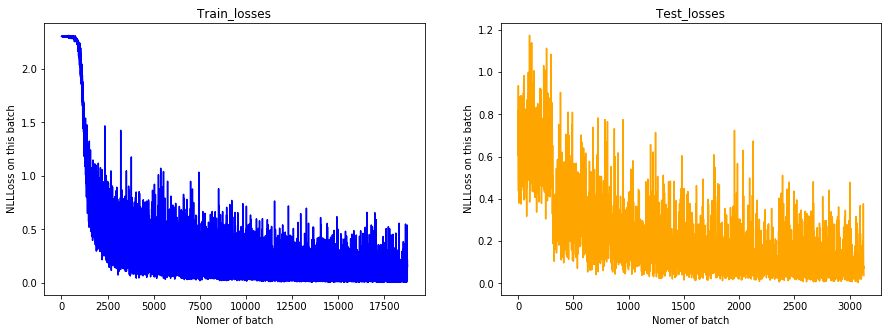

In [16]:
_,mas_relu_train,mas_relu_test=TeachNN(train_loader, test_loader,ReLU,10,0.01)
draw_losses(mas_relu_train,mas_relu_test)

100%|██████████| 10/10 [02:53<00:00, 15.87s/it]


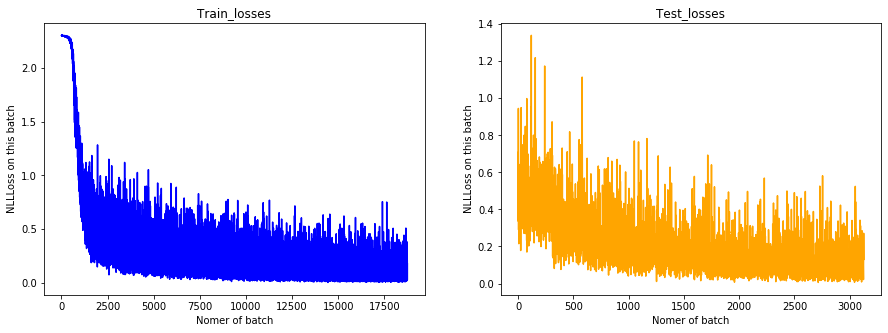

In [17]:
_,mas_elu_train,mas_elu_test=TeachNN(train_loader, test_loader,ELU,10,0.01)
draw_losses(mas_elu_train,mas_elu_test)

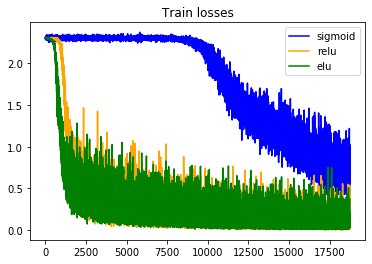

In [25]:
plt.plot(np.arange(len(mas_sigm_train)),mas_sigm_train,c='blue',label='sigmoid') 
plt.plot(np.arange(len(mas_relu_train)),mas_relu_train,c='orange',label='relu') 
plt.plot(np.arange(len(mas_elu_train)),mas_elu_train,c='green',label='elu') 
plt.legend()
plt.title("Train losses")
plt.show()

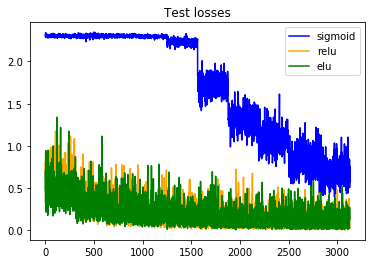

In [26]:
plt.plot(np.arange(len(mas_sigm_test)),mas_sigm_test,c='blue',label='sigmoid') 
plt.plot(np.arange(len(mas_relu_test)),mas_relu_test,c='orange',label='relu') 
plt.plot(np.arange(len(mas_elu_test)),mas_elu_test,c='green',label='elu') 
plt.legend()
plt.title("Test losses")
plt.show()

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

Обучим сеть с ELU, потому что она сходится быстрее всего:

100%|██████████| 50/50 [12:16<00:00, 14.56s/it]


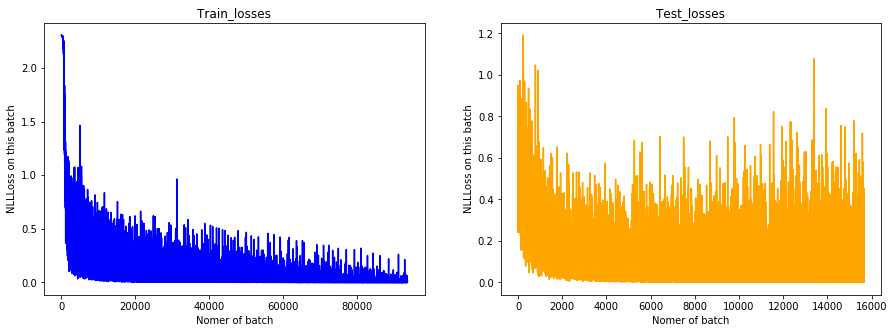

In [161]:
nn,mas_elu_train,mas_elu_test=TeachNN(train_loader, test_loader,ELU,50,0.01)
draw_losses(mas_elu_train,mas_elu_test)

Видим, что сеть переобучилась! 

Найдем объекты, которые мы плохо классифицировали:

In [154]:
to_draw=[]
for X, y in test_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() 
    y = y.numpy()
    
    preds=nn.forward(X)
    
    #Softmax
    preds=np.exp(preds)
    preds/=preds.sum(-1).reshape(-1,1)
    
    for ps,y_i,x_i in zip(preds,y,X):
        y_pred=np.argmax(ps)
        if (y_pred!=y_i):
            print("{}(p={:.2})-{}(p={:.2})".format(y_pred, ps[y_pred],y_i,ps[y_i]))
            to_draw.append((x_i,"{}(p={:.2})-{}(p={:.2})".format(y_pred, ps[y_pred],y_i,ps[y_i])))
        
#         if (len(to_draw)>=25):
#             break
    
#     if (len(to_draw)>=25):
#             break
    

7(p=0.62)-2(p=0.012)
9(p=0.51)-3(p=0.00011)
9(p=0.54)-3(p=0.0033)
8(p=0.88)-7(p=0.12)
3(p=0.65)-8(p=0.006)
3(p=0.97)-7(p=0.027)
3(p=0.94)-5(p=0.06)
6(p=1.0)-4(p=3.6e-05)
1(p=1.0)-6(p=4.5e-06)
9(p=1.0)-4(p=0.0036)
1(p=0.97)-7(p=0.021)
2(p=0.9)-3(p=0.014)
2(p=0.87)-4(p=0.085)
8(p=0.78)-3(p=0.22)
4(p=0.96)-6(p=0.038)
3(p=0.67)-5(p=0.33)
5(p=0.68)-6(p=0.32)
9(p=0.64)-4(p=0.35)
5(p=0.38)-6(p=0.28)
6(p=0.96)-4(p=0.0017)
6(p=0.51)-8(p=0.49)
5(p=0.38)-9(p=0.31)
7(p=0.84)-9(p=0.022)
6(p=0.92)-1(p=0.079)
3(p=0.61)-7(p=0.0087)
6(p=0.98)-1(p=0.017)
8(p=0.99)-2(p=0.00026)
5(p=0.99)-6(p=0.00017)
9(p=0.75)-5(p=0.17)
0(p=0.96)-5(p=0.035)
4(p=0.92)-9(p=0.035)
4(p=0.5)-8(p=0.17)
6(p=0.91)-8(p=0.026)
9(p=0.52)-7(p=0.48)
8(p=1.0)-1(p=0.00066)
9(p=0.73)-4(p=0.27)
9(p=0.85)-7(p=0.019)
5(p=0.97)-8(p=0.031)
6(p=0.29)-5(p=0.26)
4(p=0.61)-8(p=0.39)
3(p=0.69)-9(p=0.29)
7(p=0.71)-2(p=0.29)
9(p=0.86)-4(p=0.14)
7(p=0.81)-8(p=0.1)
5(p=0.7)-9(p=0.0002)
0(p=1.0)-6(p=0.0028)
8(p=0.86)-7(p=0.00012)
4(p=1.0)-9(p=0.00024)

In [155]:
len(to_draw)

224

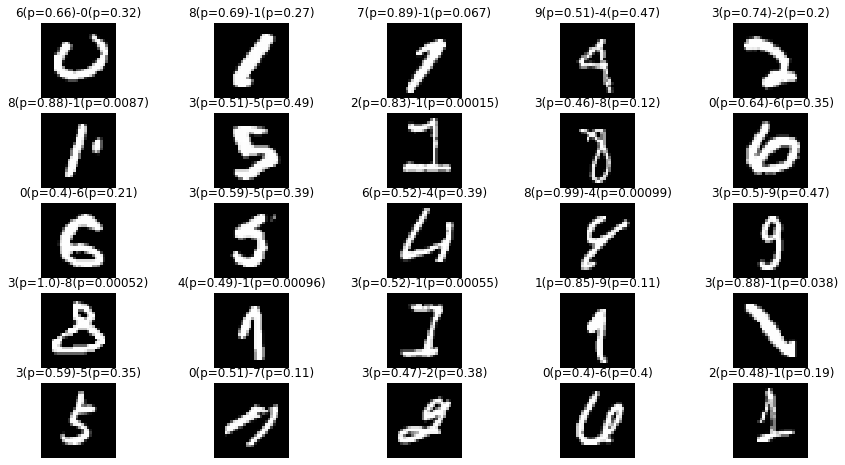

In [38]:
plt.figure(figsize=(15,8))
for i,(x_i,title) in enumerate(to_draw):
    plt.subplot(5,5, i+1)
    plt.imshow(x_i.reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(title)
    plt.axis('off')

Видим, что это действительно не очень понятные даже человеку цифры!

### HW1 (1 балл): Реализовать Tanh

In [42]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        
        self.X=X
        return (np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        chx=0.5*(np.exp(self.X)+np.exp(-self.X))
        return dLdy/(chx*chx)
    
    def step(self, learning_rate):
        pass

100%|██████████| 50/50 [13:01<00:00, 16.17s/it]


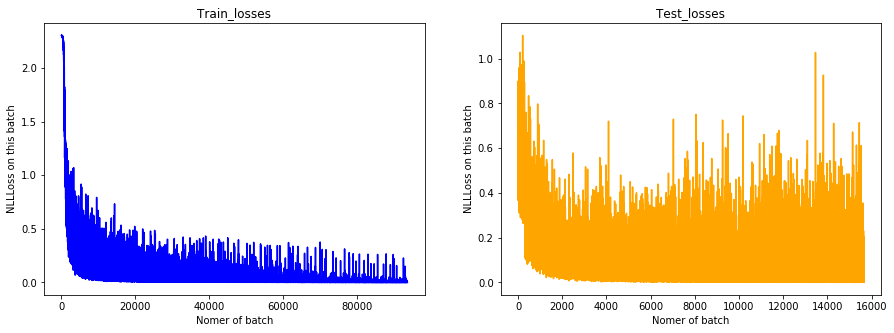

In [162]:
_,mas_tanh_train,mas_tanh_test=TeachNN(train_loader, test_loader,Tanh,50,0.01)
draw_losses(mas_tanh_train,mas_tanh_test)

Выглядит так же хорошо, как ELU!

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

Вращение сделать так: 
from skimage.transform import rotate
rotate(image, 20)

In [68]:
from skimage.transform import rotate

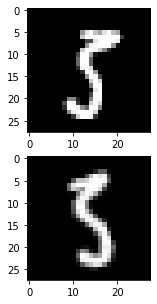

In [72]:
plt.figure(figsize=(5,5))
plt.subplot(2,1,1)
plt.imshow(X[0].reshape(28, 28), cmap=plt.cm.Greys_r)
plt.subplot(2,1,2)
plt.imshow(rotate(X[0].reshape(28, 28), mode='constant',cval=-0.42,angle=20), cmap=plt.cm.Greys_r)

In [75]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Сдвиг сделать так: np.roll(mas,5,axis=1)

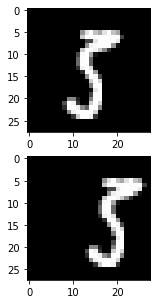

In [52]:
plt.figure(figsize=(5,5))
plt.subplot(2,1,1)
plt.imshow(X[0].reshape(28, 28), cmap=plt.cm.Greys_r)
plt.subplot(2,1,2)
plt.imshow(np.roll(X[0].reshape(28, 28),5,axis=1), cmap=plt.cm.Greys_r)

Но мы так поворачивать не будем

In [99]:
transformRR = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.RandomRotation((-15,15)),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_datasetRR = MNIST('.', train=True, download=True, transform=transformRR)
test_datasetRR = MNIST('.', train=False, transform=transformRR)

train_loaderRR = DataLoader(train_datasetRR, batch_size=32, shuffle=True)
test_loaderRR = DataLoader(test_datasetRR, batch_size=32, shuffle=True)

100%|██████████| 50/50 [40:33<00:00, 40.42s/it]


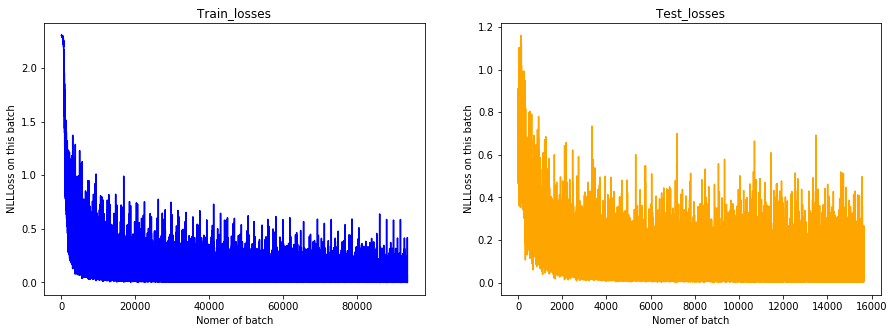

In [156]:
_,mas_tanh_trainRR,mas_tanh_testRR=TeachNN(train_loaderRR, test_loaderRR,Tanh,50,0.01)
draw_losses(mas_tanh_trainRR,mas_tanh_testRR)

Видим, что нейросеть явно переобучилась - потому что лосс на трейне падает, а на тесте - растет

In [128]:
def get_loaders(my_transform):
    train_dataset = MNIST('.', train=True, download=True, transform=my_transform)
    test_dataset = MNIST('.', train=False, transform=my_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    
    return train_loader, test_loader

In [129]:
transformShift = transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.RandomRotation((-15,15)),
                       transforms.RandomAffine(degrees=0, translate=(0.3,0.3),  fill=-0.42),                 
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_loaderShift, test_loaderShift = get_loaders(transformShift)

100%|██████████| 50/50 [35:03<00:00, 41.98s/it]


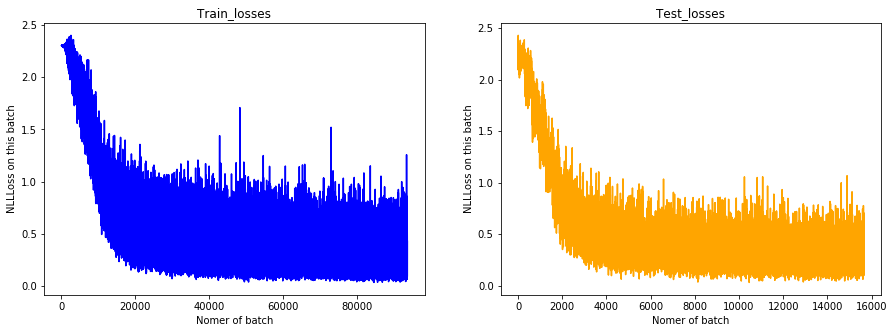

In [157]:
_,mas_tanh_trainShift,mas_tanh_testShift=TeachNN(train_loaderShift, test_loaderShift,Tanh,50,0.01)
draw_losses(mas_tanh_trainShift,mas_tanh_testShift)

In [ ]:
from torch import randn_like

In [139]:
transformNoise = transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.RandomRotation((-15,15)),
                       #transforms.RandomAffine(degrees=0, translate=(0.3,0.3),  fill=-0.42), 
                        transforms.Lambda(lambda x : x + 0.05*randn_like(x)),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_loaderNoise, test_loaderNoise = get_loaders(transformNoise)

100%|██████████| 50/50 [14:44<00:00, 17.63s/it]


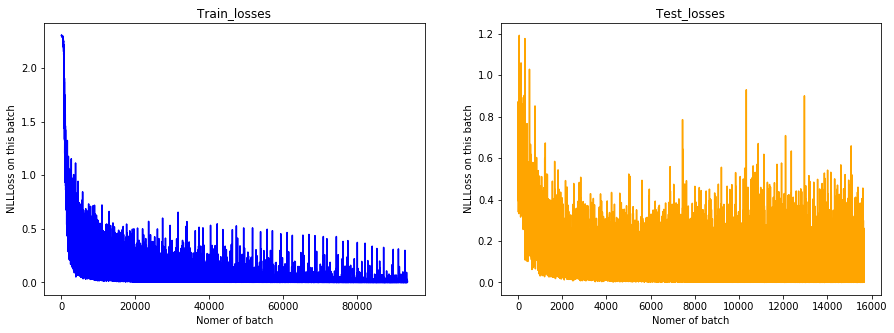

In [158]:
_,mas_tanh_trainNoise,mas_tanh_testNoise=TeachNN(train_loaderNoise, test_loaderNoise,Tanh,50,0.01)
draw_losses(mas_tanh_trainNoise,mas_tanh_testNoise)

In [143]:
transformAll = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.RandomRotation((-15,15)),
                       transforms.RandomAffine(degrees=0, translate=(0.3,0.3),  fill=-0.42), 
                        transforms.Lambda(lambda x : x + 0.05*randn_like(x)),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_loaderAll, test_loaderAll = get_loaders(transformAll)

100%|██████████| 50/50 [55:09<00:00, 66.08s/it]


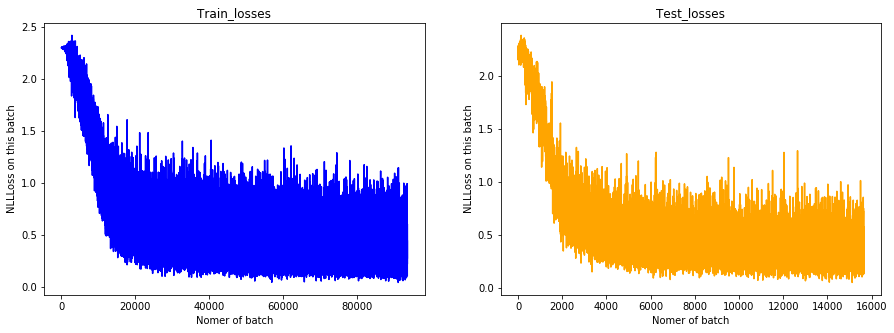

In [159]:
_,mas_tanh_trainAll,mas_tanh_testAll=TeachNN(train_loaderAll, test_loaderAll,Tanh,50,0.01)
draw_losses(mas_tanh_trainAll,mas_tanh_testAll)

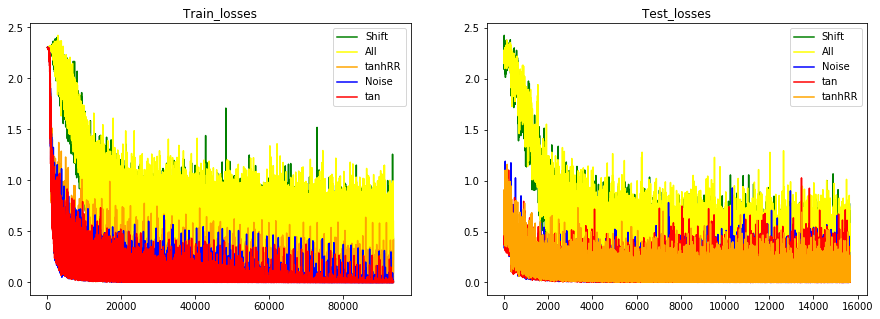

In [171]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)


axes[0].plot(np.arange(len(mas_tanh_trainShift)),mas_tanh_trainShift,c='green',label='Shift')
axes[0].plot(np.arange(len(mas_tanh_trainAll)),mas_tanh_trainAll,c='yellow',label='All')  
axes[0].plot(np.arange(len(mas_tanh_trainRR)),mas_tanh_trainRR,c='orange',label='tanhRR')
axes[0].plot(np.arange(len(mas_tanh_trainNoise)),mas_tanh_trainNoise,c='blue',label='Noise')
axes[0].plot(np.arange(len(mas_tanh_train)),mas_tanh_train,c='red',label='tan')

axes[0].set_title('Train_losses')
axes[0].legend()




axes[1].plot(np.arange(len(mas_tanh_testShift)),mas_tanh_testShift,c='green',label='Shift') 
axes[1].plot(np.arange(len(mas_tanh_testAll)),mas_tanh_testAll,c='yellow',label='All') 
axes[1].plot(np.arange(len(mas_tanh_testNoise)),mas_tanh_testNoise,c='blue',label='Noise')
axes[1].plot(np.arange(len(mas_tanh_test)),mas_tanh_test,c='red',label='tan') 
axes[1].plot(np.arange(len(mas_tanh_testRR)),mas_tanh_testRR,c='orange',label='tanhRR')
axes[1].set_title('Test_losses')
axes[1].legend()

plt.show()




Видим, что самый лучший вариант - это tanh+рандомные сдвиги

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

Сначала Relu

100%|██████████| 50/50 [17:27<00:00, 16.33s/it]


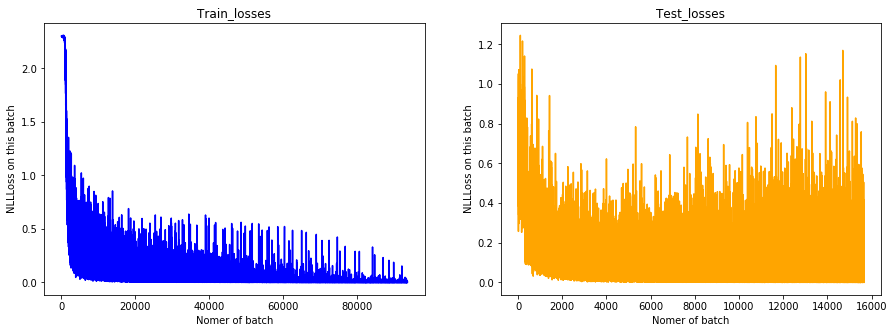

In [176]:
_,mas_relu_train,mas_relu_test=TeachNN(train_loader, test_loader,ReLU,50,0.01)
draw_losses(mas_relu_train,mas_relu_test)

100%|██████████| 50/50 [39:14<00:00, 42.80s/it]


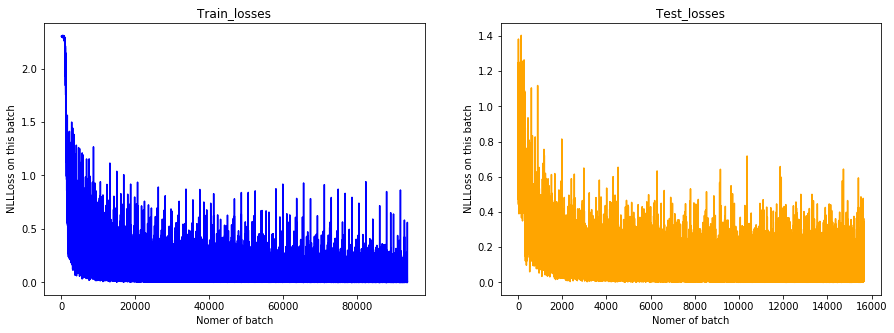

In [177]:
_,mas_relu_trainRR,mas_relu_testRR=TeachNN(train_loaderRR, test_loaderRR,ReLU,50,0.01)
draw_losses(mas_relu_trainRR,mas_relu_testRR)

100%|██████████| 50/50 [39:21<00:00, 50.75s/it]


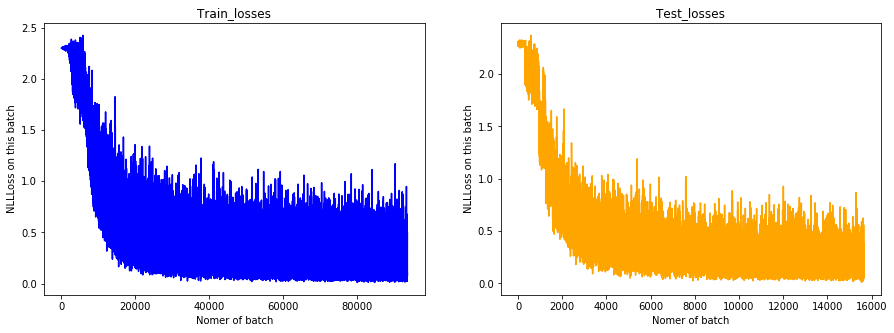

In [178]:
_,mas_relu_trainShift,mas_relu_testShift=TeachNN(train_loaderShift, test_loaderShift,ReLU,50,0.01)
draw_losses(mas_relu_trainShift,mas_relu_testShift)

100%|██████████| 50/50 [16:32<00:00, 18.30s/it]


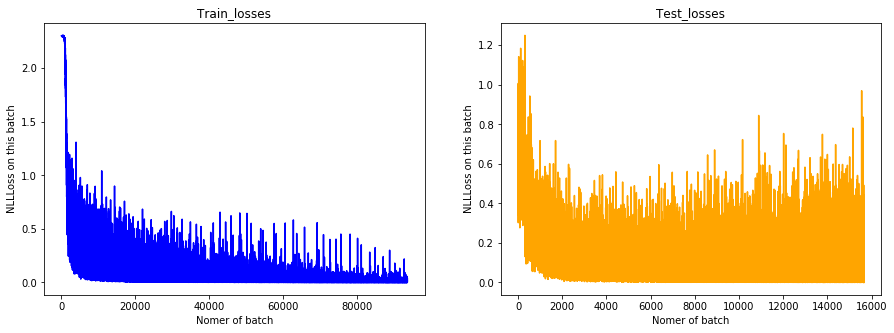

In [179]:
_,mas_relu_trainNoise,mas_relu_testNoise=TeachNN(train_loaderNoise, test_loaderNoise,ReLU,50,0.01)
draw_losses(mas_relu_trainNoise,mas_relu_testNoise)

100%|██████████| 50/50 [55:28<00:00, 68.47s/it]


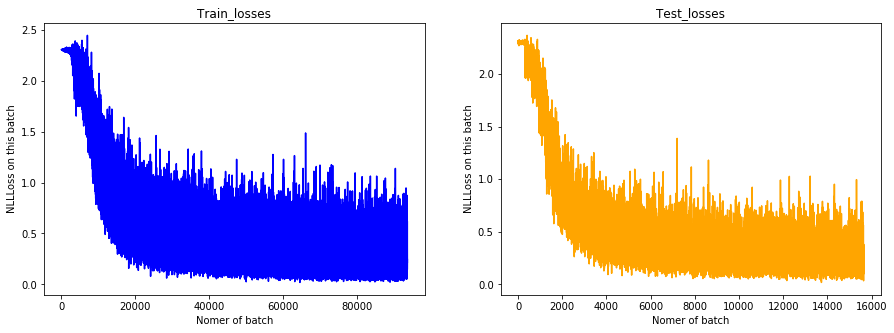

In [174]:
_,mas_relu_trainAll,mas_relu_testAll=TeachNN(train_loaderAll, test_loaderAll,ReLU,50,0.01)
draw_losses(mas_relu_trainAll,mas_relu_testAll)

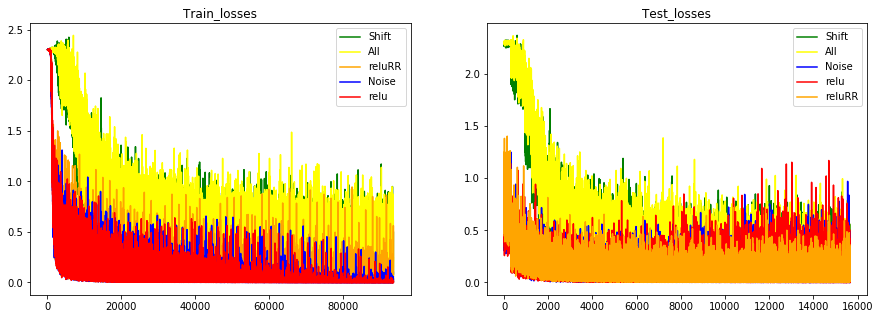

In [187]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)


axes[0].plot(np.arange(len(mas_relu_trainShift)),mas_relu_trainShift,c='green',label='Shift')
axes[0].plot(np.arange(len(mas_relu_trainAll)),mas_relu_trainAll,c='yellow',label='All')  
axes[0].plot(np.arange(len(mas_relu_trainRR)),mas_relu_trainRR,c='orange',label='reluRR')
axes[0].plot(np.arange(len(mas_relu_trainNoise)),mas_relu_trainNoise,c='blue',label='Noise')
axes[0].plot(np.arange(len(mas_relu_train)),mas_relu_train,c='red',label='relu')

axes[0].set_title('Train_losses')
axes[0].legend()




axes[1].plot(np.arange(len(mas_relu_testShift)),mas_relu_testShift,c='green',label='Shift') 
axes[1].plot(np.arange(len(mas_relu_testAll)),mas_relu_testAll,c='yellow',label='All') 
axes[1].plot(np.arange(len(mas_relu_testNoise)),mas_relu_testNoise,c='blue',label='Noise')
axes[1].plot(np.arange(len(mas_relu_test)),mas_relu_test,c='red',label='relu') 
axes[1].plot(np.arange(len(mas_relu_testRR)),mas_relu_testRR,c='orange',label='reluRR')
axes[1].set_title('Test_losses')
axes[1].legend()

plt.show()





Видим, что на тесте Relu и ReluNoise уже начинают переобучаться, в отличие от Tanh

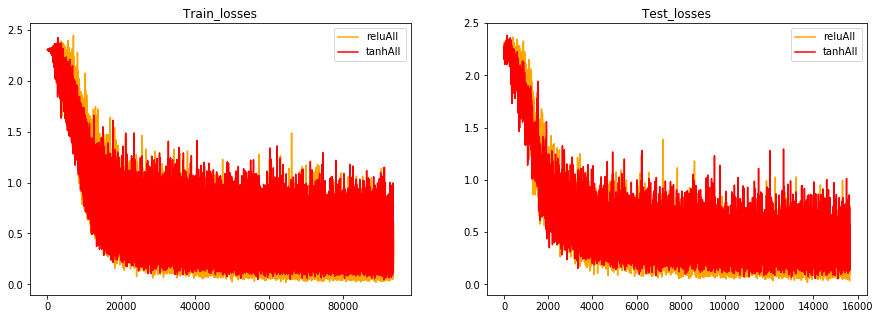

In [190]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)


# axes[0].plot(np.arange(len(mas_relu_trainShift)),mas_relu_trainShift,c='green',label='Shift')
# axes[0].plot(np.arange(len(mas_relu_trainAll)),mas_relu_trainAll,c='yellow',label='All')  
axes[0].plot(np.arange(len(mas_relu_trainAll)),mas_relu_trainAll,c='orange',label='reluAll')
axes[0].plot(np.arange(len(mas_tanh_trainAll)),mas_tanh_trainAll,c='red',label='tanhAll')
# axes[0].plot(np.arange(len(mas_relu_trainNoise)),mas_relu_trainNoise,c='blue',label='Noise')
# axes[0].plot(np.arange(len(mas_relu_train)),mas_relu_train,c='red',label='relu')

axes[0].set_title('Train_losses')
axes[0].legend()




# axes[1].plot(np.arange(len(mas_relu_testShift)),mas_relu_testShift,c='green',label='Shift') 
# axes[1].plot(np.arange(len(mas_relu_testAll)),mas_relu_testAll,c='yellow',label='All') 
# axes[1].plot(np.arange(len(mas_relu_testNoise)),mas_relu_testNoise,c='blue',label='Noise')
# axes[1].plot(np.arange(len(mas_relu_test)),mas_relu_test,c='red',label='relu') 
axes[1].plot(np.arange(len(mas_relu_testAll)),mas_relu_testAll,c='orange',label='reluAll')
axes[1].plot(np.arange(len(mas_tanh_testAll)),mas_tanh_testAll,c='red',label='tanhAll')
axes[1].set_title('Test_losses')
axes[1].legend()

plt.show()






В принципе, Tanh и Relu сходятся почти одинаково, только relu немного позже начинает сходиться

Теперь ELU

100%|██████████| 50/50 [13:48<00:00, 16.56s/it]


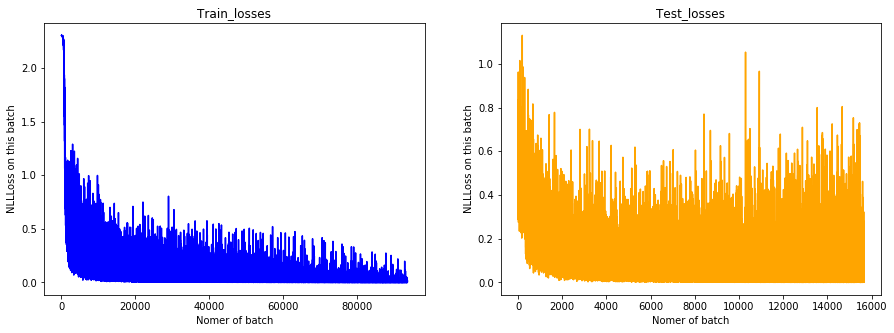

In [180]:
_,mas_elu_train,mas_elu_test=TeachNN(train_loader, test_loader,ELU,50,0.01)
draw_losses(mas_elu_train,mas_elu_test)

100%|██████████| 50/50 [36:46<00:00, 45.15s/it]


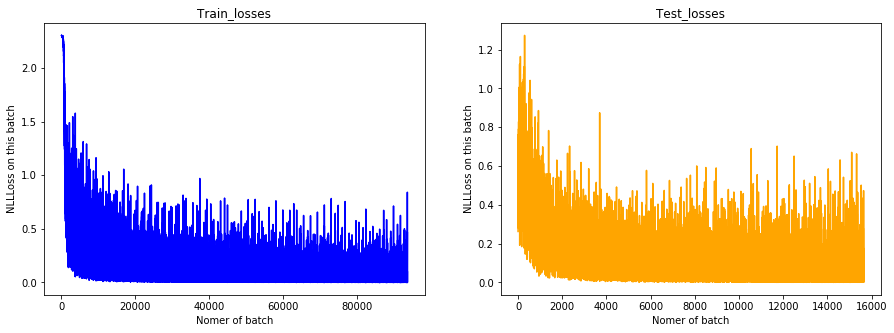

In [181]:
_,mas_elu_trainRR,mas_elu_testRR=TeachNN(train_loaderRR, test_loaderRR,ELU,50,0.01)
draw_losses(mas_elu_trainRR,mas_elu_testRR)

100%|██████████| 50/50 [40:34<00:00, 51.85s/it]


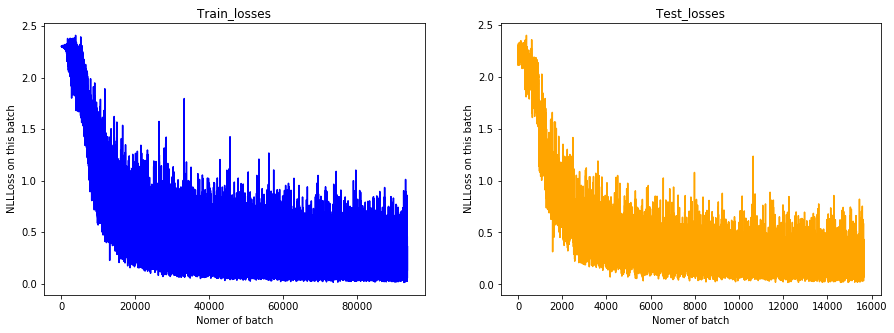

In [182]:
_,mas_elu_trainShift,mas_elu_testShift=TeachNN(train_loaderShift, test_loaderShift,ELU,50,0.01)
draw_losses(mas_elu_trainShift,mas_elu_testShift)

100%|██████████| 50/50 [15:36<00:00, 17.69s/it]


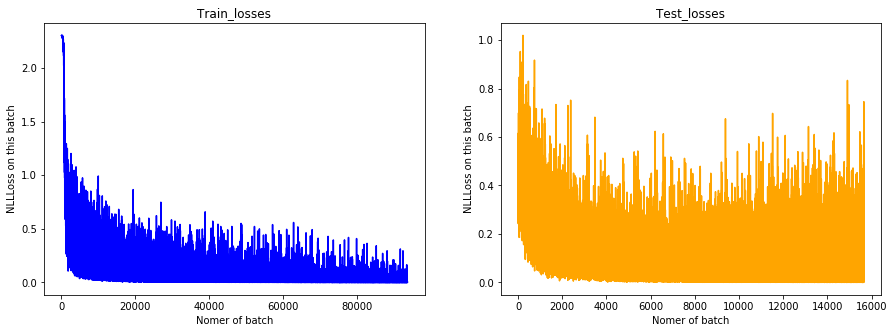

In [183]:
_,mas_elu_trainNoise,mas_elu_testNoise=TeachNN(train_loaderNoise, test_loaderNoise,ELU,50,0.01)
draw_losses(mas_elu_trainNoise,mas_elu_testNoise)

100%|██████████| 50/50 [55:13<00:00, 66.23s/it]


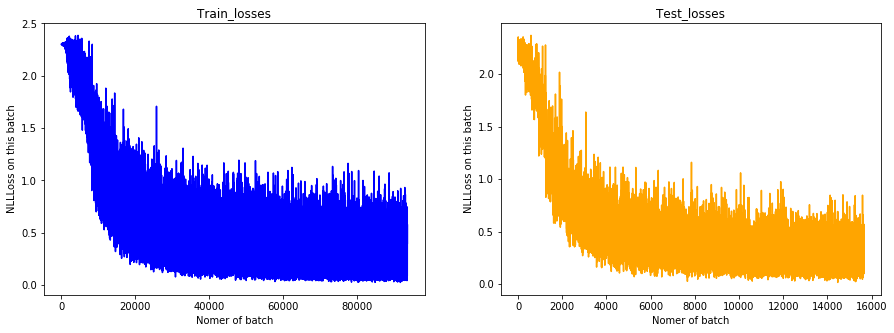

In [184]:
_,mas_elu_trainAll,mas_elu_testAll=TeachNN(train_loaderAll, test_loaderAll,ELU,50,0.01)
draw_losses(mas_elu_trainAll,mas_elu_testAll)

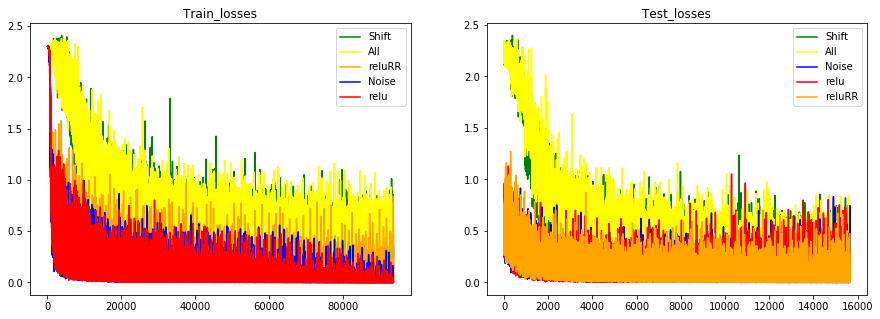

In [191]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)


axes[0].plot(np.arange(len(mas_elu_trainShift)),mas_elu_trainShift,c='green',label='Shift')
axes[0].plot(np.arange(len(mas_elu_trainAll)),mas_elu_trainAll,c='yellow',label='All')  
axes[0].plot(np.arange(len(mas_elu_trainRR)),mas_elu_trainRR,c='orange',label='reluRR')
axes[0].plot(np.arange(len(mas_elu_trainNoise)),mas_elu_trainNoise,c='blue',label='Noise')
axes[0].plot(np.arange(len(mas_elu_train)),mas_elu_train,c='red',label='relu')

axes[0].set_title('Train_losses')
axes[0].legend()




axes[1].plot(np.arange(len(mas_elu_testShift)),mas_elu_testShift,c='green',label='Shift') 
axes[1].plot(np.arange(len(mas_elu_testAll)),mas_elu_testAll,c='yellow',label='All') 
axes[1].plot(np.arange(len(mas_elu_testNoise)),mas_elu_testNoise,c='blue',label='Noise')
axes[1].plot(np.arange(len(mas_elu_test)),mas_elu_test,c='red',label='relu') 
axes[1].plot(np.arange(len(mas_elu_testRR)),mas_elu_testRR,c='orange',label='reluRR')
axes[1].set_title('Test_losses')
axes[1].legend()

plt.show()






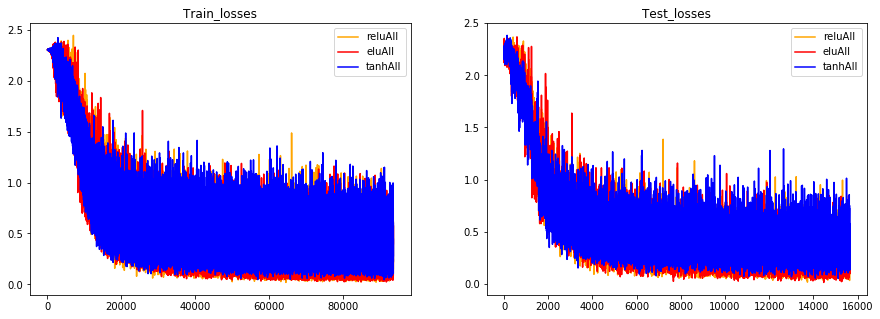

In [194]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)


# axes[0].plot(np.arange(len(mas_relu_trainShift)),mas_relu_trainShift,c='green',label='Shift')
# axes[0].plot(np.arange(len(mas_relu_trainAll)),mas_relu_trainAll,c='yellow',label='All')  
axes[0].plot(np.arange(len(mas_relu_trainAll)),mas_relu_trainAll,c='orange',label='reluAll')
axes[0].plot(np.arange(len(mas_elu_trainAll)),mas_elu_trainAll,c='red',label='eluAll')
axes[0].plot(np.arange(len(mas_tanh_trainAll)),mas_tanh_trainAll,c='blue',label='tanhAll')
# axes[0].plot(np.arange(len(mas_relu_trainNoise)),mas_relu_trainNoise,c='blue',label='Noise')
# axes[0].plot(np.arange(len(mas_relu_train)),mas_relu_train,c='red',label='relu')

axes[0].set_title('Train_losses')
axes[0].legend()




# axes[1].plot(np.arange(len(mas_relu_testShift)),mas_relu_testShift,c='green',label='Shift') 
# axes[1].plot(np.arange(len(mas_relu_testAll)),mas_relu_testAll,c='yellow',label='All') 
# axes[1].plot(np.arange(len(mas_relu_testNoise)),mas_relu_testNoise,c='blue',label='Noise')
# axes[1].plot(np.arange(len(mas_relu_test)),mas_relu_test,c='red',label='relu') 
axes[1].plot(np.arange(len(mas_relu_testAll)),mas_relu_testAll,c='orange',label='reluAll')
axes[1].plot(np.arange(len(mas_elu_testAll)),mas_elu_testAll,c='red',label='eluAll')
axes[1].plot(np.arange(len(mas_tanh_testAll)),mas_tanh_testAll,c='blue',label='tanhAll')
axes[1].set_title('Test_losses')
axes[1].legend()

plt.show()







Видим, что tanh быстрее начинает сходиться, но падает до чуть-чуть меньшего уровня,  чем elu и relu

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

1) Сигмоида очень долго учится и поздно начинает падать, ее использовать не надо

2) Tanh/relu/elu хороши сами по себе, быстро сходятся, но на 50 эпохах уже переобучаются

3) Из предобработок   не переобучаются RandomRotation и Shift, а Noise переобучается

4) Noise работает быстро, а Shift и RandomRotation - в 3 раза медленнее

5) Из аугментаций лучше всего работает RandomRotation

6) Самый хороший вариант - Relu/Elu+RandomRotation, чуть меньше скор на тесте дает Tanh+RandomRotation

7) И все-таки 50 эпох много, потому что после 25 эпох даже с аугментацией начинается переобучение